In [12]:
#--------------------------------------------------------------------------------
#Module 1
#--------------------------------------------------------------------------------
import os
import pandas as pd

# Ensure the directory "Processed data" exists before attempting to load the file
if os.path.exists("Processed data/data_encoded.csv"):
    data_encoded = pd.read_csv("Processed data/data_encoded.csv")
else:
    print("The CSV file does not exist in the specified directory.")

#import pickle
#import os

# Ensure the directory "Processed data" exists before attempting to load the file
#if os.path.exists("Processed data/data_encoded.csv"):
 #   with open("Processed data/data_encoded.csv", "rb") as file:
  #      data_encoded = file
   #     print(data_encoded.columns)
#else:
 #   print("The pickled file does not exist in the specified directory.")


In [13]:
#--------------------------------------------------------------------------------
# Module 2: Define the Generator model
#--------------------------------------------------------------------------------

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout, GaussianNoise

# Define the size of the random noise input (latent dimension)
latent_dim = 100
num_features = data_encoded.shape[1]

def build_generator():
    model = Sequential()

    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
   # model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
   # model.add(Dense(2048))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(GaussianNoise(0.1))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.1))
    
    model.add(Dense(num_features, activation='sigmoid'))

    return model

generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               51712     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_7 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1024)              0         
                                                      

In [14]:
#--------------------------------------------------------------------------------
# Module 3: Define the Discriminator model
#--------------------------------------------------------------------------------

from tensorflow.keras.regularizers import l2

def build_discriminator():
    model = Sequential()

    model.add(Dense(64, input_dim = num_features, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(64*4, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(64*8, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(64*16, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(64*32, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                22592     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64)                0         
                                                                 
 batch_normalization_9 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 256)               16640     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 256)               0         
                                                      

In [15]:
#--------------------------------------------------------------------------------
# Module 4: Compile the Discriminator model
#   1. Using legacy Keras optimizer as i have an m2 chip macbook
#--------------------------------------------------------------------------------

from tensorflow.keras.optimizers.legacy import Adam

# Compile the Discriminator using the legacy optimizer ALTERNATIVES: 'mean_squared_error'
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])



In [16]:
#--------------------------------------------------------------------------------
# Module 5: Combined GAN Structure
#   OBS! Discriminator trainable=False as we dont wants to change its weights 
#   while during this initial generator training process.
#--------------------------------------------------------------------------------

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Ensure that the discriminator is not trainable when combined with the generator
discriminator.trainable = False

# Define the GAN's input (noise) and output (discriminator's probability for the generated sample)
gan_input = Input(shape=(latent_dim,))
generated_sample = generator(gan_input)
gan_output = discriminator(generated_sample)

# Define the combined GAN model
gan = Model(gan_input, gan_output)

# Compile the GAN using the same loss and optimizer as the discriminator
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))

gan.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 352)               943968    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 2812993   
                                                                 
Total params: 3756961 (14.33 MB)
Trainable params: 940896 (3.59 MB)
Non-trainable params: 2816065 (10.74 MB)
_________________________________________________________________


In [17]:
#--------------------------------------------------------------------------------
# Module 6: Training the GAN
#--------------------------------------------------------------------------------

import numpy as np

# Define training hyperparameters
epochs = 500
batch_size = 64 #120
half_batch = batch_size // 2

# Lists to hold loss and accuracy values for plotting after training
d_losses = []
d_accuracies = []
g_losses = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Select a random half batch of real samples
    idx = np.random.randint(0, data_encoded.shape[0], half_batch)
    real_samples = data_encoded.iloc[idx].values.astype('float32')

    # Generate half batch of fake samples
    noise = np.random.normal(0, 1, (half_batch, latent_dim)).astype('float32')
    fake_samples = generator.predict(noise).astype('float32')

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((half_batch, 1)).astype('float32'))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((half_batch, 1)).astype('float32'))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype('float32')
    valid_y = np.ones((batch_size, 1)).astype('float32')
    
    # Train the generator
    g_loss = gan.train_on_batch(noise, valid_y)

    # Save losses and accuracy for plotting
    d_losses.append(d_loss[0])
    d_accuracies.append(100 * d_loss[1])
    g_losses.append(g_loss)

    # Print the progress
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

print("Training finished.")


1/1 [==============================] - 0s 175ms/step
0/500 [D loss: 3.7225635051727295 | D accuracy: 45.3125] [G loss: 3.428501605987549]
1/1 [==============================] - 0s 20ms/step
1/500 [D loss: 3.7856829166412354 | D accuracy: 48.4375] [G loss: 3.3529551029205322]
1/1 [==============================] - 0s 20ms/step
2/500 [D loss: 3.5667638778686523 | D accuracy: 48.4375] [G loss: 3.351083755493164]
1/1 [==============================] - 0s 20ms/step
3/500 [D loss: 3.7925541400909424 | D accuracy: 39.0625] [G loss: 3.3169453144073486]
1/1 [==============================] - 0s 20ms/step
4/500 [D loss: 3.6214736700057983 | D accuracy: 45.3125] [G loss: 3.3462162017822266]
1/1 [==============================] - 0s 24ms/step
5/500 [D loss: 3.64040207862854 | D accuracy: 45.3125] [G loss: 3.353346347808838]
1/1 [==============================] - 0s 30ms/step
6/500 [D loss: 3.5164319276809692 | D accuracy: 57.8125] [G loss: 3.3401103019714355]
1/1 [==============================] -

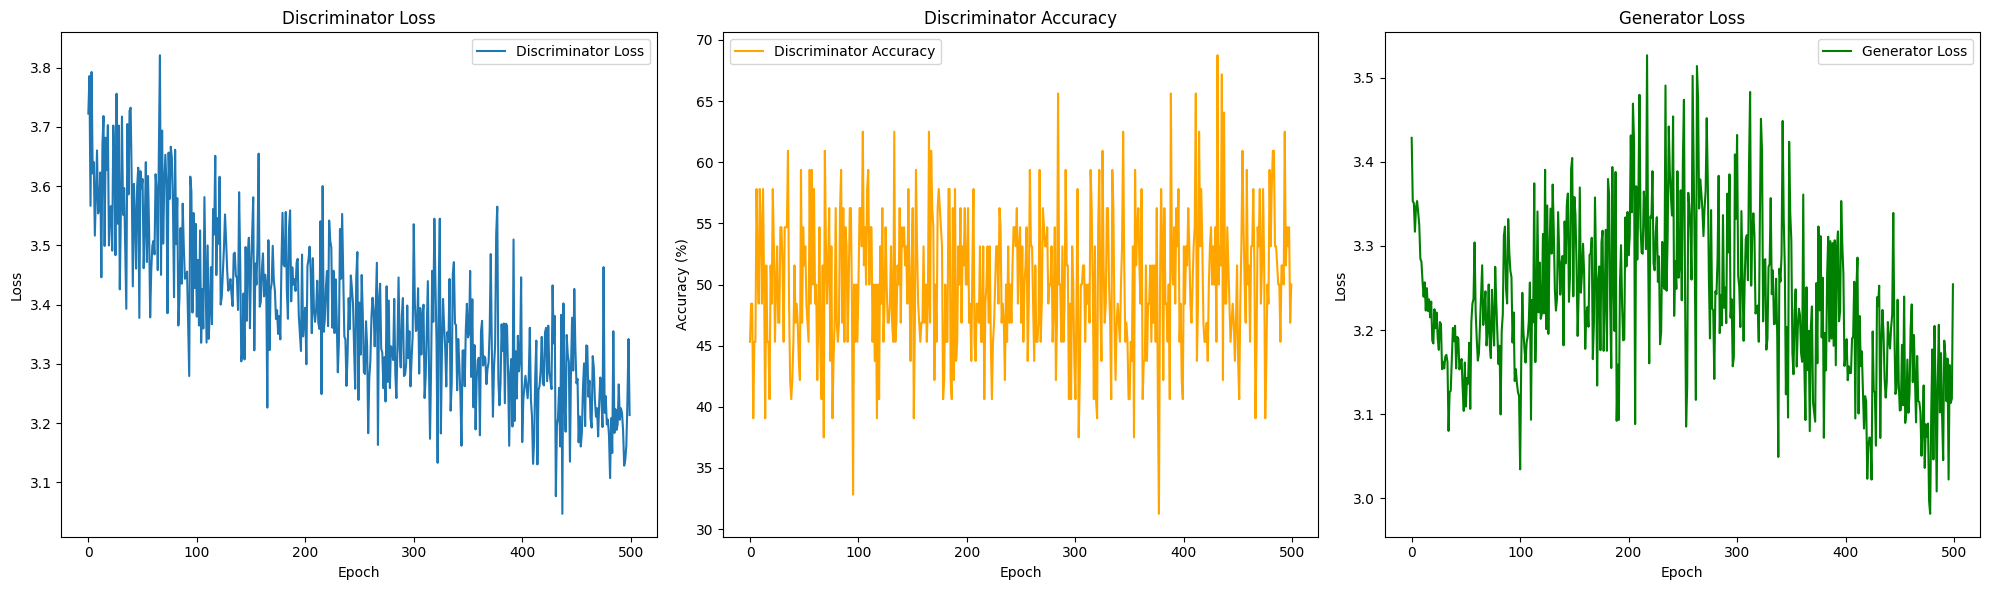

In [18]:
#--------------------------------------------------------------------------------
# Module 7: Visualize the Loss and Accuracy
#--------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Create a new figure for the plots
plt.figure(figsize=(20, 6))

# Plotting Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Discriminator Accuracy
plt.subplot(1, 3, 2)
plt.plot(d_accuracies, label='Discriminator Accuracy', color='orange')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting Generator Loss
plt.subplot(1, 3, 3)
plt.plot(g_losses, label='Generator Loss', color='green')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
#--------------------------------------------------------------------------------
# Module 8: Synthetic Data Generation and Inverse Transformation
# 1. This module defines a function to generate synthetic data samples using a GAN.
# 2. It then inverses the one-hot encoding and normalization transformations to obtain
#    data in a format similar to the original input data. The resulting synthetic data 
#    is then printed for inspection. 
#--------------------------------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model

# Load the original and encoded data
data = pd.read_csv("Cleaned Data/RT.IRS_Clean_v2.csv")
data_encoded = pd.read_csv("Processed data/data_encoded.csv")

# Define latent dimension used in the generator
latent_dim = 100  # This should match the latent dimension used in your generator

def generate_and_inverse_transform(generator, num_samples=20):
    # Generate synthetic data using the GAN
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    generated_samples = generator.predict(noise)

    # Convert generated samples to DataFrame
    generated_df = pd.DataFrame(generated_samples, columns=data_encoded.columns)

    # Inverse one-hot encoding to get original categorical columns
    categorical_columns = [col for col in data.columns if data[col].dtype == 'object']
    for original_col in categorical_columns:
        one_hot_cols = [col for col in generated_df.columns if col.startswith(original_col + "_")]
        if one_hot_cols:
            # Find the column with the highest value for each row
            max_col = generated_df[one_hot_cols].idxmax(axis=1)
            # Extract the category name and assign it to the original column
            generated_df[original_col] = max_col.apply(lambda x: x.replace(original_col + "_", ""))
            # Drop the one-hot columns
            generated_df.drop(one_hot_cols, axis=1, inplace=True)

    # Inverse normalization to get the original values of numerical columns
    numerical_columns = data_encoded.select_dtypes(include=['float64', 'int64']).columns
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(data[numerical_columns])  # Fit the scaler to the original data
    generated_df[numerical_columns] = scaler.inverse_transform(generated_df[numerical_columns])

    # Ensure all columns from the original data are present in generated_df
    for col in data.columns:
        if col not in generated_df.columns:
            generated_df[col] = np.nan

    # Ensure the columns are in the same order as the original data
    generated_df = generated_df[data.columns]

    return generated_df

# Call the function and print synthetic data
synthetic_data = generate_and_inverse_transform(generator)


/var/folders/sn/v85b1fvn22v4g_yk95dpk_s80000gn/T/ipykernel_10538/3907644582.py:15: DtypeWarning: Columns (9,40,41,44,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Cleaned Data/RT.IRS_Clean_v2.csv")


1/1 [==============================] - 0s 87ms/step


In [20]:
#--------------------------------------------------------------------------------
# Module 9: Testing the GAN model
#--------------------------------------------------------------------------------
from scipy.stats import ks_2samp
import numpy as np

#Numerical columns test
def evaluate_gan_using_ks_test(real_data, generated_data):
    ks_results = {}
    for column in real_data.columns:
        # Ensure the column is numerical before applying the KS test
        if np.issubdtype(real_data[column].dtype, np.number) and np.issubdtype(generated_data[column].dtype, np.number):
            ks_statistic, p_value = ks_2samp(real_data[column], generated_data[column])
            ks_results[column] = {'KS Statistic': ks_statistic, 'p-value': p_value}
        #else:
         #   ks_results[column] = {'Error': 'Non-numerical data'}
    print(ks_results)
    return ks_results



# Assuming real_data and generated_data are Pandas DataFrames with the same columns
ks_test_results = evaluate_gan_using_ks_test(data, synthetic_data)



#categorical columns test
def evaluate_gan_categorical(real_data, generated_data, top_n=5):
    categorical_results = {}
    for column in real_data.columns:
        # Skip numerical columns
        if np.issubdtype(real_data[column].dtype, np.number) and np.issubdtype(generated_data[column].dtype, np.number):
            continue

        # Handle cases where data types might be mixed in a column
        real_data[column] = real_data[column].astype(str)
        generated_data[column] = generated_data[column].astype(str)

        # Calculate frequency distribution for real and generated data
        frequency_real = real_data[column].value_counts(normalize=True).head(top_n)
        frequency_generated = generated_data[column].value_counts(normalize=True).head(top_n)

        # Create a detailed comparison
        comparison = pd.DataFrame({
            'Real Frequency': frequency_real,
            'Generated Frequency': frequency_generated
        }).fillna(0)  # Fill missing values with 0

        # Store the result
        categorical_results[column] = comparison.to_dict()
    print(categorical_results)
    return categorical_results

# Evaluate categorical data
categorical_test_results = evaluate_gan_categorical(data, synthetic_data, top_n=5)


{'Upfront Payment': {'KS Statistic': 1.0, 'p-value': 0.0}, 'Leg 1 Fixed Rate': {'KS Statistic': 0.9990567105610686, 'p-value': 6.22199184797001e-61}, 'Leg 1 Spread': {'KS Statistic': 0.9994717579141984, 'p-value': 5.723872851325638e-66}, 'Leg 1 Notional': {'KS Statistic': 0.9987171263630532, 'p-value': 2.9154634765309982e-58}, 'Leg 2 Fixed Rate': {'KS Statistic': 0.9993208316039693, 'p-value': 8.721262659354125e-64}, 'Leg 2 Spread': {'KS Statistic': 0.9990567105610686, 'p-value': 6.22199184797001e-61}, 'Leg 2 Notional': {'KS Statistic': 0.9987171263630532, 'p-value': 2.9154634765309982e-58}, 'Option Strike Price': {'KS Statistic': 1.0, 'p-value': 0.0}, 'Option Currency': {'KS Statistic': 0.0, 'p-value': 1.0}, 'Option Premium': {'KS Statistic': 1.0, 'p-value': 0.0}, 'Future Value Notional': {'KS Statistic': 0.9859638531487002, 'p-value': 1.7619276132562755e-37}}
{'Event': {'Real Frequency': {'DSF': 0.011923178508093423, 'Full Netting': 0.0255820095838207, 'New Trade': 0.908199071803192,

In [21]:
#--------------------------------------------------------------------------------
# Module 10: Generate Synthesized Data and Save to CSV
#--------------------------------------------------------------------------------

def save_synthesized_data(generator, num_samples=1000, output_file_path="Synthesized Data (GAN)/synthesized_data_GAN.csv"):
    # Generate synthetic data
    synthetic_data = generate_and_inverse_transform(generator, num_samples=num_samples)
    
    # Save the synthesized data to a CSV file
    print(output_file_path)
    synthetic_data.to_csv(output_file_path, index=False)

    
    print(f"Synthesized data generated and saved to {output_file_path}")

# Call the function to generate and save the synthetic data
save_synthesized_data(generator)
evaluate_gan_using_ks_test(data, synthetic_data)
evaluate_gan_categorical(data,synthetic_data)

#print("Real data columns:", data.columns)
#print("Generated data columns:", synthetic_data.columns)



32/32 [==============================] - 0s 1ms/step
Synthesized Data (GAN)/synthesized_data_GAN.csv
Synthesized data generated and saved to Synthesized Data (GAN)/synthesized_data_GAN.csv
{'Upfront Payment': {'KS Statistic': 1.0, 'p-value': 0.0}, 'Leg 1 Fixed Rate': {'KS Statistic': 0.9990567105610686, 'p-value': 6.22199184797001e-61}, 'Leg 1 Spread': {'KS Statistic': 0.9994717579141984, 'p-value': 5.723872851325638e-66}, 'Leg 1 Notional': {'KS Statistic': 0.9987171263630532, 'p-value': 2.9154634765309982e-58}, 'Leg 2 Fixed Rate': {'KS Statistic': 0.9993208316039693, 'p-value': 8.721262659354125e-64}, 'Leg 2 Spread': {'KS Statistic': 0.9990567105610686, 'p-value': 6.22199184797001e-61}, 'Leg 2 Notional': {'KS Statistic': 0.9987171263630532, 'p-value': 2.9154634765309982e-58}, 'Option Strike Price': {'KS Statistic': 1.0, 'p-value': 0.0}, 'Option Currency': {'KS Statistic': 0.0, 'p-value': 1.0}, 'Option Premium': {'KS Statistic': 1.0, 'p-value': 0.0}, 'Future Value Notional': {'KS Stati

{'Event': {'Real Frequency': {'DSF': 0.011923178508093423,
   'Full Netting': 0.0255820095838207,
   'New Trade': 0.908199071803192,
   'Other': 0.006980341848092669,
   'Partial Netting': 0.020450515036033658,
   'nan': 0.0},
  'Generated Frequency': {'DSF': 0.0,
   'Full Netting': 0.0,
   'New Trade': 0.0,
   'Other': 0.0,
   'Partial Netting': 0.0,
   'nan': 1.0}},
 'Execution Timestamp': {'Real Frequency': {'2015-06-16 23:59:59': 0.00679168396030638,
   '2017-04-06 00:00:00': 0.003961815643512055,
   '2018-05-24 19:45:00': 0.005395615590687847,
   '2022-09-07 00:00:00': 0.0031317209372523865,
   '2022-11-02 00:00:00': 0.003056257782137871,
   'nan': 0.0},
  'Generated Frequency': {'2015-06-16 23:59:59': 0.0,
   '2017-04-06 00:00:00': 0.0,
   '2018-05-24 19:45:00': 0.0,
   '2022-09-07 00:00:00': 0.0,
   '2022-11-02 00:00:00': 0.0,
   'nan': 1.0}},
 'Dissemination Time': {'Real Frequency': {'2015-06-16 23:59:59': 0.00679168396030638,
   '2017-04-06 00:00:00': 0.003961815643512055,
  

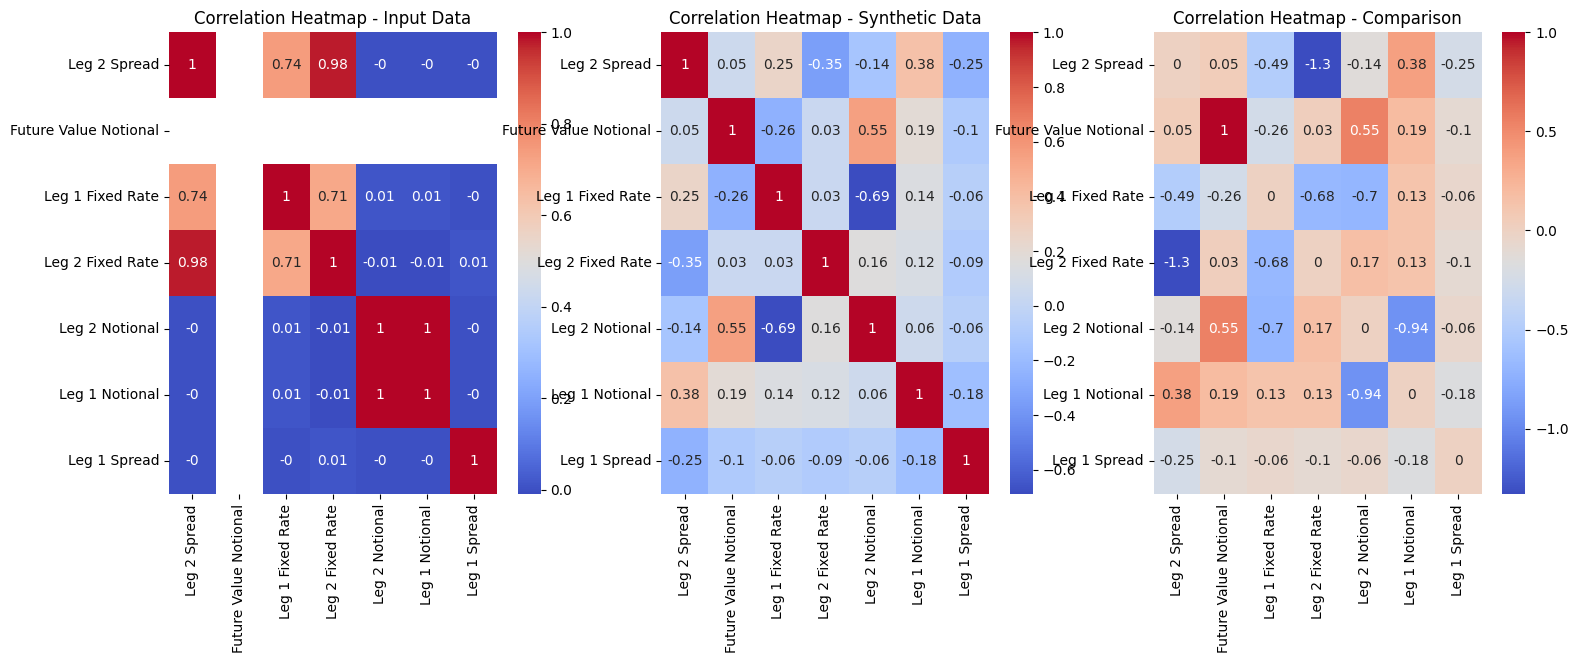

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming input_data and synthetic_data are already loaded in previous cells
# If not, uncomment and use the following lines to load your datasets
input_data = data_encoded
# synthetic_data = pd.read_csv('path_to_synthesized_data_GAN.csv')

# Identify common numeric columns
common_columns = list(set(input_data.columns) & set(synthetic_data.columns))
common_numeric_columns = [col for col in common_columns if pd.api.types.is_numeric_dtype(input_data[col])]

# Filter both datasets to these common numeric columns
input_data_filtered = input_data[common_numeric_columns].dropna(axis=1, how='all')
synthetic_data_filtered = synthetic_data[common_numeric_columns].dropna(axis=1, how='all')

# Ensuring both datasets have the same final set of columns
final_common_columns = list(set(input_data_filtered.columns) & set(synthetic_data_filtered.columns))
input_data_final = input_data_filtered[final_common_columns]
synthetic_data_final = synthetic_data_filtered[final_common_columns]

# Compute the correlation matrices for the filtered datasets
corr_matrix_input = round(input_data_final.corr(), 2)
corr_matrix_synthetic = round(synthetic_data_final.corr(),2)
#Difference between them
corr_diff = round(corr_matrix_synthetic.subtract(corr_matrix_input, fill_value=0),2)
# Plot heatmaps for the input and synthetic data
plt.figure(figsize=(18, 6))

# Heatmap for Input Data
plt.subplot(1, 3, 1)
sns.heatmap(corr_matrix_input, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap - Input Data')

# Heatmap for Synthetic Data
plt.subplot(1, 3, 2)
sns.heatmap(corr_matrix_synthetic, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap - Synthetic Data')

#Heatmap for comparison

plt.subplot(1, 3, 3)
sns.heatmap(corr_diff, cmap='coolwarm', annot=True)
plt.title("Correlation Heatmap - Comparison")
plt.show()
